# Direct Regression

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm
#from cinspect import dependence, importance
from sklearn.model_selection import cross_val_score, cross_validate
import pickle
import time

from reed import drop_missing_treatment_or_outcome, Model

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100

%matplotlib inline

%load_ext autoreload
%autoreload 2

sklearn.__version__

'1.0'

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)

#### Select modeling parameters

In [2]:
outcome = 'y_Dwsce'#'y_wsce'
treatment = 'redufl'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=False
cross_val_cache = "data/cross-val-all.pkl"
bootstrap_cache = "data/bootstrap-all.pkl"

### Load Data 
   - drop rows missing the specified treatment or outcome

In [3]:
data = pd.read_csv("all_vars.csv",index_col='xwaveid')
drop_missing_treatment_or_outcome(data, treatment, outcome)
if log_outcome:
    data[outcome] = np.log(data[outcome]+data[outcome].min())

Dropped 592 rows missing treatment or outcome.


### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [4]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('ridge',Ridge(), 
              parameters = {
                  'alpha':np.logspace(-1,4,30)
              },
              importance_func=importance_from_coef
        ),
        Model('lasso',Lasso(),
              parameters = {
                  'alpha':np.logspace(-2,4,30)
              },
              importance_func=importance_from_coef
        ), 
        Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
              parameters = {
                'max_features':[10,20,40,60,80],
                'learning_rate':np.logspace(-3,0,10),
                'min_samples_leaf':np.logspace(0,3,10).astype(int)
              }
        ),
    ]
    return models

# def construct_models(): Used for quick testing
#     models = [
#         Model('Ridge',Ridge(),
#               parameters = {'alpha':np.logspace(1,4,2)},
#               importance_func=importance_from_coef
#         ),
#         Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
#               parameters = {
#                 'max_features':[10],
#                 'learning_rate':np.logspace(-3,0,2),
#               }
#         ), 
#     ]
#     return models

### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [5]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)

print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)


Control data dimensions:  (3659, 638)
Treated data dimensions: (1295, 638)


### Compute unconditional/unadjusted estimate of treatment effect

In [6]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:26%
Average outcome under Control:67.85±15.36
Average outcome under Treatment:310.57±29.39
Unadjusted treatment estimate 242.72


### Propensity model

- Run primarily to check for violations over overlap assumptions.

In [7]:
from reed import visualise_propensity_model_performance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

X_train, X_test, t_train, t_test = train_test_split(X,t,stratify=t)
pmodel = LogisticRegressionCV(Cs = np.logspace(-5,-1,20), penalty='l2', max_iter=10000)
pmodel.fit(X_train, t_train);

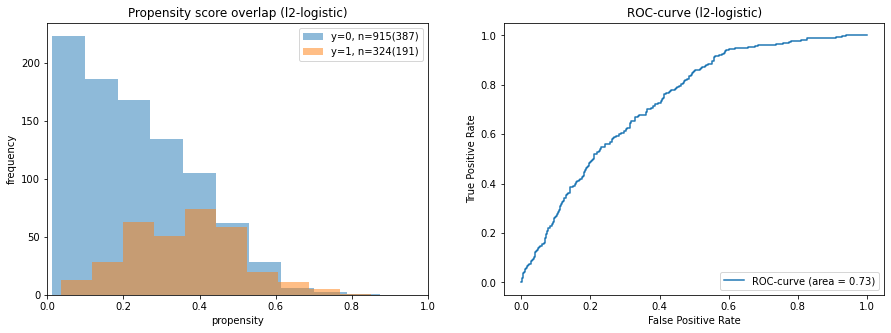

In [8]:
visualise_propensity_model_performance(t_test, pmodel.predict_proba(X_test)[:,1],'l2-logistic',bins=10)

In [9]:
def propensity_coefficients(model, features):
    if hasattr(model,'best_estimator_'):
        model = model.best_estimator_
    coef = model.coef_[0]
    
    with open('data/metadata.pkl','rb') as f:
        meta = pickle.load(f)
        labels = [meta.column_names_to_labels.get(f) for f in features]
    return pd.DataFrame({'label': labels, "c":coef,'abs':np.abs(coef)},index=features).sort_values(by='abs',ascending=False).head(50)
print("Propensity Model Coefficients")      
propensity_coefficients(pmodel, features).head(20)

Propensity Model Coefficients


,label,c,abs
aedq524,DV: ASCED 524 Certificate level I - Number of qualifications obtained since leaving school,0.075018,0.075018
ajbocct,DV: Tenure in current occupation (years),-0.071395,0.071395
ahgage,DV: Age last birthday at June 30 2001,-0.067138,0.067138
aehttot,D3 Total years since left school - Manual addition,-0.065106,0.065106
ahgsex,HF3 Sex,0.059512,0.059512
aedqenr,C6 Ever enrolled in a course of study to obtain a qualification,-0.053356,0.053356
ajbempt,DV: Tenure with current employer (years),-0.052635,0.052635
amrcdur,DV: Current marriage duration - years,-0.052320,0.052320
aordf1mt,"J8 Month began living together, first defacto relationship excluding current",0.050062,0.050062
aehtjbyr,D3a1 Years in paid work,-0.049900,0.049900


### (Nested) cross-validate to evaluate model performance
![image.png](images/nested_cross_val.png)

In [10]:
from direct_regression import nested_cross_val
models0, models1, results = nested_cross_val(
    construct_models,
    cross_val_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=5,
    outercv=20,
    load_from_cache=True
)

### Report estimate ATE and model performance

  - Mean and Std of prediction performance for each model (both treatment & control surface)
  - Mean and Std of average treatment effect for each model

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
ridge,32.43,17.85,0.21,0.04,0.16,0.05,"-688,459.25","117,049.27","-937,229.77","228,178.97"
lasso,12.60,21.54,0.21,0.04,0.23,0.08,"-682,934.95","111,734.07","-869,897.33","231,965.57"
gbr,33.92,30.89,0.26,0.05,0.17,0.07,"-644,545.72","110,096.12","-936,660.69","259,663.97"


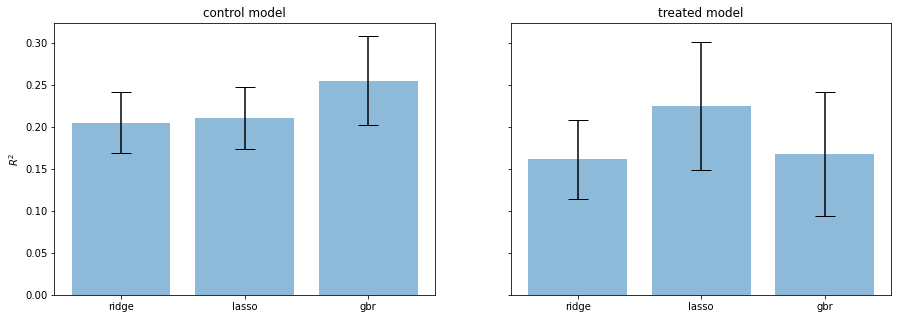

In [11]:
from direct_regression import visualise_ate
visualise_ate(results,X,evaluation_metrics);

### Visualise models
- Features responsible for treatment effect heterogeneity & functional form (with uncertainty)
      - coefficeints for linear models
      - TODO permutation importance & partial dependence curves for non-linear models

In [12]:
from direct_regression import display_feature_importance
display_feature_importance(models0, models1, results, features);

ridge


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
awscmei,67.392175,5.371911,-7.386898,12.555713,-7.108562e+01,8.675093e+00,-63.698726,7.828191
ahgage,38.314974,1.871172,1.097868,2.064772,-3.776604e+01,2.215085e+00,-38.863908,2.056115
ahiwscmi,36.362816,2.100656,15.844493,10.380130,-2.844057e+01,5.149319e+00,-44.285062,6.015278
aehttot,35.313115,2.152391,-1.756363,1.328987,-3.619130e+01,2.440478e+00,-34.434933,2.047620
aehtjbyr,34.970354,2.042174,1.982229,1.431604,-3.397924e+01,2.020007e+00,-35.961468,2.298971
...,...,...,...,...,...,...,...,...
aoifrpt,0.569735,0.379192,-1.105305,0.819154,2.136689e-29,9.627163e-30,1.105305,0.819154
abncob,0.567920,0.385846,1.135841,0.771692,3.203073e-29,1.469974e-29,-1.135841,0.771692
abncobi,0.499964,0.225187,0.999928,0.450373,1.446873e-29,7.380840e-30,-0.999928,0.450373


### Compare against OLS on basic variables

In [16]:
basic = pd.read_csv("basic_variables.csv",index_col='xwaveid')
drop_missing_treatment_or_outcome(basic, treatment, outcome)
if log_outcome:
    basic[outcome] = np.log(basic[outcome]+basic[outcome].min())
    
X0b, X1b, y0b, y1b, Xb, yb, tb, featuresb = seperate_and_transform_data(basic, treatment, outcome)

def construct_basic_model():
    models = [
        Model('OLS',LinearRegression(),importance_func=importance_from_coef)
    ]
    return models

modelsb0, modelsb1, resultsb = nested_cross_val(
    construct_basic_model,
    "data/tmp.pkl",
    X0b, X1b, y0b, y1b,
    optimisation_metric,
    evaluation_metrics,
    innercv=5,
    outercv=20,
    load_from_cache=False)

Dropped 592 rows missing treatment or outcome.
Fitting OLS ...Done
Caching results to data/tmp.pkl


(0.2996426443784309, 0.3329968222052687)

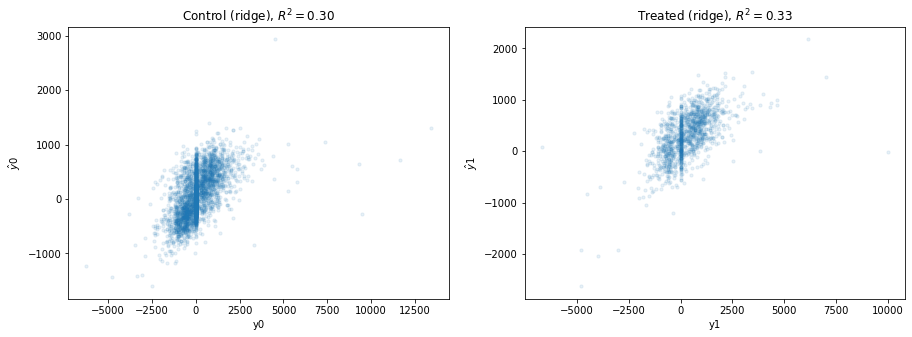

In [61]:
y0a = results['ridge'][0]['estimator'][1].predict(X0)
y1a = results['ridge'][1]['estimator'][1].predict(X1)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(y0, y0a,s=10,alpha=0.1)
ax[0].set_xlabel('y0')
ax[0].set_ylabel('$\\hat{y}0$');
ax[0].set_title(f'Control (ridge), $R^2={r2_score(y0,y0a):.2f}$')

ax[1].scatter(y1, y1a,s=10,alpha=0.1)
ax[1].set_xlabel('y1')
ax[1].set_ylabel('$\\hat{y}1$');
ax[1].set_title(f'Treated (ridge), $R^2={r2_score(y1,y1a):.2f}$');

# think about why these r2 scores are higher than on the holdout set (and whether they are likely overfitting)

Text(0.5, 1.0, 'Treated (OLS-basic), $R^2=0.17$')

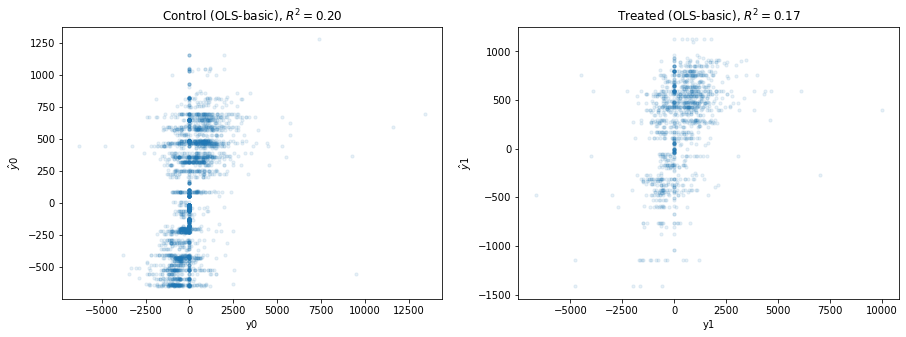

In [59]:
from sklearn.metrics import r2_score
y0b = resultsb['OLS'][0]['estimator'][0].predict(X0b)
y1b = resultsb['OLS'][1]['estimator'][0].predict(X1b)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(y0, y0b,s=10,alpha=0.1)
ax[0].set_xlabel('y0')
ax[0].set_ylabel('$\\hat{y}0$');
ax[0].set_title(f'Control (OLS-basic), $R^2={r2_score(y0,y0b):.2f}$')

ax[1].scatter(y1, y1b,s=10,alpha=0.1)
ax[1].set_xlabel('y1')
ax[1].set_ylabel('$\\hat{y}1$');
ax[1].set_title(f'Treated (OLS-basic), $R^2={r2_score(y1,y1b):.2f}$');


### Bootstraped cross-validation to estimate parameter uncertainty
![image.png](images/bootstrap_validation.png)

In [13]:
def extract_params(estimator):
    return estimator.coef_

def bootstrapped_cross_val(
    optimisation_metric,
    extract_params_func,
    inner_cv = 3,
    load_from_cache=False, 
    cache_name=bootstrap_cache, 
    samples=1
):
    if load_from_cache:
        with open(cache_name, 'rb') as f:
            results = pickle.load(f)
    else:
        models = construct_models()
        results = {}
        start = time.time()
        for model in models:
            print(f"Fitting {model.name} ...",end='')
            results0 = model.bootstrap_cv_evaluate(X0,y0,optimisation_metric,extract_params,
                                                   bootstrap_samples=samples,return_estimator=True)
            results1 = model.bootstrap_cv_evaluate(X1,y1,optimisation_metric,extract_params,
                                                   bootstrap_samples=samples,return_estimator=True)
            results[model.name] = (results0, results1)
            print("Done")
        total = time.time()-start
        print(f"Total time:{total} seconds")
        print(f"Caching results to: {cache_name}")
        with open(cache_name,'wb') as f:
            pickle.dump(results,f)
    
    return results

bootstrap_results = bootstrapped_cross_val(
    optimisation_metric, 
    extract_params,
    load_from_cache=False,
    inner_cv=5,
    samples=100
)

Fitting Ridge ...Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Done
Fitting gbr ...Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Done
Total time:3.9828720092773438 seconds
Caching results to: data/bootstrap-all.pkl


####  Average treatment effects

In [15]:
from direct_regression import estimate_causal_effect
for model_name, (results0, results1) in bootstrap_results.items():
    models0 = [r['estimator'] for r in results0]
    models1 = [r['estimator'] for r in results1]
    ate = estimate_causal_effect(X,models0, models1)
    print(f'{model_name}, {ate.mean():.2f} ± {ate.std()}')  

Ridge, 82.22 ± 22.86
gbr, 239.39 ± 17.34


#### Distribution of hyper-parameters

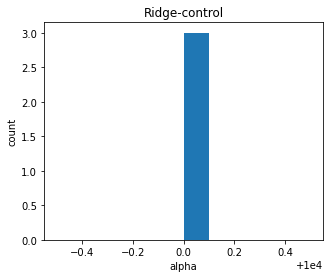

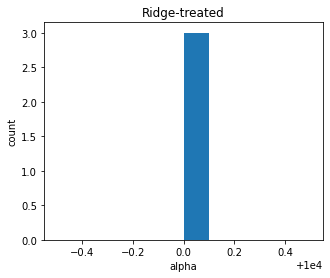

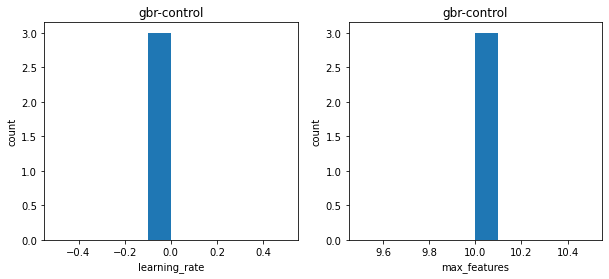

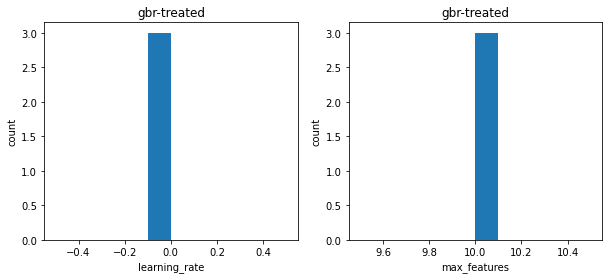

In [16]:
from collections import defaultdict
def hyperparam_distributions(samples) -> {str:[]}:
    """Returns a dict from hyper-parameter name to the best values for that hyper-parameter over the samples."""
    distributions = defaultdict(list)
    for sample in samples:
        h = sample['estimator'].best_params_
        for key, value in h.items():
            distributions[key].append(value)
    return distributions

def plot_hyperparam_distributions(samples, title) -> None:
    distributions = hyperparam_distributions(samples)
    k = len(distributions)
    fig, axes = plt.subplots(1,k,figsize=(k*5,4))
    if k == 1:
        axes = [axes]
    for i, (key, values) in enumerate(distributions.items()):
        ax = axes[i]
        ax.hist(values)
        ax.set_title(title)
        ax.set_xlabel(key)
        ax.set_ylabel('count')
    return fig,axes

for model, (results0, results1) in bootstrap_results.items():
    plot_hyperparam_distributions(results0,f"{model}-control")
    plot_hyperparam_distributions(results1,f"{model}-treated")